# Collaboration and Competition

---

In this notebook, you will learn how to use the Unity ML-Agents environment for the third project of the [Deep Reinforcement Learning Nanodegree](https://www.udacity.com/course/deep-reinforcement-learning-nanodegree--nd893) program.

### 1. Start the Environment

We begin by importing the necessary packages.  If the code cell below returns an error, please revisit the project instructions to double-check that you have installed [Unity ML-Agents](https://github.com/Unity-Technologies/ml-agents/blob/master/docs/Installation.md) and [NumPy](http://www.numpy.org/).

In [1]:
from unityagents import UnityEnvironment
import numpy as np
import random
import copy

# from ddpg_agent import Agent
from collections import namedtuple, deque
import torch
import matplotlib.pyplot as plt

import torch
import torch.nn.functional as F
import torch.optim as optim

Next, we will start the environment!  **_Before running the code cell below_**, change the `file_name` parameter to match the location of the Unity environment that you downloaded.

- **Mac**: `"path/to/Tennis.app"`
- **Windows** (x86): `"path/to/Tennis_Windows_x86/Tennis.exe"`
- **Windows** (x86_64): `"path/to/Tennis_Windows_x86_64/Tennis.exe"`
- **Linux** (x86): `"path/to/Tennis_Linux/Tennis.x86"`
- **Linux** (x86_64): `"path/to/Tennis_Linux/Tennis.x86_64"`
- **Linux** (x86, headless): `"path/to/Tennis_Linux_NoVis/Tennis.x86"`
- **Linux** (x86_64, headless): `"path/to/Tennis_Linux_NoVis/Tennis.x86_64"`

For instance, if you are using a Mac, then you downloaded `Tennis.app`.  If this file is in the same folder as the notebook, then the line below should appear as follows:
```
env = UnityEnvironment(file_name="Tennis.app")
```

In [2]:
env = UnityEnvironment(file_name="./Tennis")

INFO:unityagents:
'Academy' started successfully!
Unity Academy name: Academy
        Number of Brains: 1
        Number of External Brains : 1
        Lesson number : 0
        Reset Parameters :
		
Unity brain name: TennisBrain
        Number of Visual Observations (per agent): 0
        Vector Observation space type: continuous
        Vector Observation space size (per agent): 8
        Number of stacked Vector Observation: 3
        Vector Action space type: continuous
        Vector Action space size (per agent): 2
        Vector Action descriptions: , 


Environments contain **_brains_** which are responsible for deciding the actions of their associated agents. Here we check for the first brain available, and set it as the default brain we will be controlling from Python.

In [3]:
# get the default brain
brain_name = env.brain_names[0]
brain = env.brains[brain_name]

### 2. Examine the State and Action Spaces

In this environment, two agents control rackets to bounce a ball over a net. If an agent hits the ball over the net, it receives a reward of +0.1.  If an agent lets a ball hit the ground or hits the ball out of bounds, it receives a reward of -0.01.  Thus, the goal of each agent is to keep the ball in play.

The observation space consists of 8 variables corresponding to the position and velocity of the ball and racket. Two continuous actions are available, corresponding to movement toward (or away from) the net, and jumping. 

Run the code cell below to print some information about the environment.

In [4]:
# reset the environment
env_info = env.reset(train_mode=True)[brain_name]

# number of agents 
num_agents = len(env_info.agents)
print('Number of agents:', num_agents)

# size of each action
action_size = brain.vector_action_space_size
print('Size of each action:', action_size)

# examine the state space 
states = env_info.vector_observations
state_size = states.shape[1]
print('There are {} agents. Each observes a state with length: {}'.format(states.shape[0], state_size))
print('The state for the first agent looks like:', states[0])

Number of agents: 2
Size of each action: 2
There are 2 agents. Each observes a state with length: 24
The state for the first agent looks like: [ 0.          0.          0.          0.          0.          0.
  0.          0.          0.          0.          0.          0.
  0.          0.          0.          0.         -6.65278625 -1.5
 -0.          0.          6.83172083  6.         -0.          0.        ]


In [5]:
# for i in range(1, 6):                                      # play game for 5 episodes
#     env_info = env.reset(train_mode=False)[brain_name]     # reset the environment    
#     states = env_info.vector_observations                  # get the current state (for each agent)
#     scores = np.zeros(num_agents)                          # initialize the score (for each agent)
#     while True:
#         actions = np.random.randn(num_agents, action_size) # select an action (for each agent)
#         actions = np.clip(actions, -1, 1)                  # all actions between -1 and 1
#         env_info = env.step(actions)[brain_name]           # send all actions to tne environment
#         next_states = env_info.vector_observations         # get next state (for each agent)
#         rewards = env_info.rewards                         # get reward (for each agent)
#         dones = env_info.local_done                        # see if episode finished
#         scores += env_info.rewards                         # update the score (for each agent)
#         states = next_states                               # roll over states to next time step
#         if np.any(dones):                                  # exit loop if episode finished
#             break
#     print('Score (max over agents) from episode {}: {}'.format(i, np.max(scores)))

### 3. Take Random Actions in the Environment

In the next code cell, you will learn how to use the Python API to control the agents and receive feedback from the environment.

Once this cell is executed, you will watch the agents' performance, if they select actions at random with each time step.  A window should pop up that allows you to observe the agents.

Of course, as part of the project, you'll have to change the code so that the agents are able to use their experiences to gradually choose better actions when interacting with the environment!

In [6]:
import torch
import torch.nn as nn
import torch.nn.functional as F


def _reset_parameters(layers):
    for layer in layers:
        layer.weight.data.uniform_(-3e-3,3e-3)


class Actor(nn.Module):
    """Actor (Policy) Model."""

    def __init__(self, state_size, action_size, seed, fc_layers=[128,128]):
        """Initialize parameters and build model.
        Params
        ======
            state_size (int): Dimension of each state
            action_size (int): Dimension of each action
            seed (int): Random seed
            fc_layers (list): Number of nodes in hidden layers
        """
        super(Actor, self).__init__()
        self.seed = torch.manual_seed(seed)
        # Define input and output values for the hidden layers
        dims = [state_size] + fc_layers + [action_size]
        # Create the hidden layers
        self.fc_layers = nn.ModuleList(
            [nn.Linear(dim_in, dim_out) for dim_in, dim_out in zip(dims[:-1], dims[1:])])
        # Initialize the hidden layer weights
        _reset_parameters(self.fc_layers)

        print('Actor network built:', self.fc_layers)

    def forward(self, x):
        """Build an actor (policy) network that maps states -> actions."""
        # Pass the input through all the layers apllying ReLU activation, but the last
        for layer in self.fc_layers[:-1]:
            x = F.relu(layer(x))
        # Pass the result through the output layer apllying hyperbolic tangent function
        x = torch.tanh(self.fc_layers[-1](x))
        # Return the better action for the input state
        return x


class Critic(nn.Module):
    """Critic (Value) Model."""

    def __init__(self, state_size, action_size, seed, fc_layers=[128,128]):
        """Initialize parameters and build model.
        Params
        ======
            state_size (int): Dimension of each state
            action_size (int): Dimension of each action
            seed (int): Random seed
            fc_layers (list): Number of nodes in hidden layers
        """
        super(Critic, self).__init__()
        self.seed = torch.manual_seed(seed)
        # Append the output size to the layers's dimensions
        dims = fc_layers + [1]
        # Create a list of layers
        layers_list = []
        layers_list.append(nn.Linear(state_size, dims[0]))
        # The second layer receives the the first layer output + action
        layers_list.append(nn.Linear(dims[0] + action_size, dims[1]))
        # Build the next layers, if that is the case
        for dim_in, dim_out in zip(dims[1:-1], dims[2:]):
            layers_list.append(nn.Linear(dim_in, dim_out))
        # Store the layers as a ModuleList
        self.fc_layers = nn.ModuleList(layers_list)
        # Initialize the hidden layer weights
        _reset_parameters(self.fc_layers)
        # Add batch normalization to the first hidden layer
        self.bn = nn.BatchNorm1d(dims[0])

        print('Critic network built:', self.fc_layers)

    def forward(self, state, action):
        """Build a critic (value) network that maps (state, action) pairs -> Q-values."""
        # Pass the states into the first layer
        x = self.fc_layers[0](state)
        x = self.bn(x)
        x = F.relu(x)
        # Concatenate the first layer output with the action
        x = torch.cat((x, action), dim=1)
        # Pass the input through all the layers apllying ReLU activation, but the last
        for layer in self.fc_layers[1:-1]:
            x = F.relu(layer(x))
        # Pass the result through the output layer apllying sigmoid activation
        x = torch.sigmoid(self.fc_layers[-1](x))
        # Return the Q-Value for the input state-action
        return x


In [7]:
_batch_size = 128
_buffer_size = int(1e5)
_gamma = 0.99
_lr_actor = 1e-4
_lr_critic = 1e-3
_tau = 1e-3
_noise_decay = 0.999
_device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")


class Agent():
    """Interacts with and learns from the environment."""
    
    def __init__(self, state_size, action_size, random_seed):
        """Initialize an Agent object.
        
        Params
        ======
            state_size (int): dimension of each state
            action_size (int): dimension of each action
            random_seed (int): random seed
        """
        self.state_size = state_size
        self.action_size = action_size
        self.seed = random.seed(random_seed)

        print('DDPG Agent hyperparameters:\n\t' \
              'batch size: \t\t{:8.0f}\n\t' \
              'buffer size: \t\t{:8.0f}\n\t' \
              'discount / gamma: \t{:8.3f}\n\t' \
              'actor learning rate: \t{:8.3f}\n\t' \
              'critic learning rate: \t{:8.3f}\n\t' \
              'soft update / tau: \t{:8.3f}\n\t' \
              'noise decay rate: \t{:8.3f}\n'
              .format(_batch_size, _buffer_size, _gamma,
                      _lr_actor, _lr_critic, _tau, _noise_decay))
        # Actor Network
        self.actor_local = Actor(state_size, action_size, random_seed, [400, 300]).to(_device)
        self.actor_target = Actor(state_size, action_size, random_seed, [400, 300]).to(_device)
        self.actor_optimizer = optim.Adam(self.actor_local.parameters(), lr=_lr_actor)

        # Critic Network
        self.critic_local = Critic(state_size, action_size, random_seed, [400, 300]).to(_device)
        self.critic_target = Critic(state_size, action_size, random_seed, [400, 300]).to(_device)
        self.critic_optimizer = optim.Adam(self.critic_local.parameters(), lr=_lr_critic)

        # Initialize target networks weights with the local networks ones
        self.soft_update(self.actor_local, self.actor_target, 1)
        self.soft_update(self.critic_local, self.critic_target, 1)

        # Replay Buffer
        self.replay_buffer = ReplayBuffer(random_seed)

        # Noise process
        self.noise = OUNoise(action_size, random_seed)
        self.noise_decay = _noise_decay

    def act(self, state, noise=True):
        """Returns actions for given state as per current policy."""
        state = torch.from_numpy(state).float().to(_device)

        self.actor_local.eval()
        with torch.no_grad():
            action = self.actor_local(state).data.cpu().numpy()
        self.actor_local.train()

        if noise:
            # Add noise to the action in order to explore the environment
            action += self.noise_decay * self.noise.sample()
            # Decay the noise process along the time
            self.noise_decay *= self.noise_decay

        return np.clip(action, -1, 1)

    def step(self, states, actions, rewards, next_states):
        """Save experience in replay buffer, and use random sample from buffer to learn."""
        # Save experience
        self.replay_buffer.add(states, actions, rewards, next_states)

        # Learn, if enough samples are available in memory
        if len(self.replay_buffer) > _batch_size:
            experiences = self.replay_buffer.sample()
            self.learn(experiences)

    def learn(self, experiences):
        """Update policy and value parameters using given batch of experience tuples.
        Q_targets = r + γ * critic_target(next_state, actor_target(next_state))
        where:
            actor_target(state) -> action
            critic_target(state, action) -> Q-value

        Params
        ======
            experiences (Tuple[torch.Tensor]): tuple of (s, a, r, s') tuples 
        """
        states, actions, rewards, next_states = experiences
        
        # ---------------------------- update critic ---------------------------- #
        # Get predicted next-state actions from actor_target model
        actions_next = self.actor_target(next_states)
        # Get predicted next-state Q-Values from critic_target model
        Q_targets_next = self.critic_target(next_states, actions_next)
        # Compute Q targets for current states (y_i)
        Q_targets = rewards + (_gamma * Q_targets_next)
        # Compute critic loss
        Q_expected = self.critic_local(states, actions)
        critic_loss = F.mse_loss(Q_expected, Q_targets)
        # Minimize the loss
        self.critic_optimizer.zero_grad()
        critic_loss.backward()
        # torch.nn.utils.clip_grad_norm_(self.critic_local.parameters(), 1)
        self.critic_optimizer.step()
        
        # ---------------------------- update actor ---------------------------- #
        # Compute actor loss
        actions_pred = self.actor_local(states)
        actor_loss = -self.critic_local(states, actions_pred).mean()
        # Minimize the loss
        self.actor_optimizer.zero_grad()
        actor_loss.backward()
        self.actor_optimizer.step()
        
        # ----------------------- update target networks ----------------------- #
        self.soft_update(self.critic_local, self.critic_target)
        self.soft_update(self.actor_local, self.actor_target)
        
    def soft_update(self, local_model, target_model, tau=_tau):
        """Soft update model parameters.
        θ_target = τ*θ_local + (1 - τ)*θ_target

        Params
        ======
            local_model: PyTorch model (weights will be copied from)
            target_model: PyTorch model (weights will be copied to)
        """
        for target_param, local_param in zip(target_model.parameters(), local_model.parameters()):
            target_param.data.copy_(tau*local_param.data + (1.0-tau)*target_param.data)


class ReplayBuffer:
    """Fixed-size buffer to store experience tuples."""

    def __init__(self, seed):
        """Initialize a ReplayBuffer object.

        Params
        ======
            seed (int): random seed
        """
        self.memory = deque(maxlen=_buffer_size)
        self.experience = namedtuple('Experience', field_names=['states', 'actions', 'rewards', 'next_states'])
        self.seed = random.seed(seed)
    
    def add(self, states, actions, rewards, next_states):
        """Add a new experience to memory."""
        e = self.experience(states, actions, rewards, next_states)
        self.memory.append(e)
    
    def sample(self):
        """Randomly sample a batch of experiences from memory."""
        experiences = random.sample(self.memory, k=_batch_size)
        
        states = torch.from_numpy(np.vstack([e.states for e in experiences if e is not None])).float().to(_device)
        actions = torch.from_numpy(np.vstack([e.actions for e in experiences if e is not None])).float().to(_device)
        rewards = torch.from_numpy(np.vstack([e.rewards for e in experiences if e is not None])).float().to(_device)
        next_states = torch.from_numpy(np.vstack([e.next_states for e in experiences if e is not None])).float().to(_device)

        return (states, actions, rewards, next_states)
    
    def __len__(self):
        """Return the current size of internal memory."""
        return len(self.memory)


class OUNoise:
    """Ornstein-Uhlenbeck process."""

    def __init__(self, size, seed, mu=0., theta=0.15, sigma=0.2):
        """Initialize parameters and noise process."""
        self.mu = mu * np.ones(size)
        self.theta = theta
        self.sigma = sigma
        self.seed = random.seed(seed)
        self.reset()

    def reset(self):
        """Reset the internal state (= noise) to mean (mu)."""
        self.state = copy.copy(self.mu)

    def sample(self):
        """Update internal state and return it as a noise sample."""
        x = self.state
        dx = self.theta * (self.mu - x) + self.sigma * np.array([random.random() for i in range(len(x))])
        self.state = x + dx
        return self.state


In [8]:
# Create the Agent
# agent = Agent(state_size, action_size, random_seed=0)
agent = Agent(state_size, action_size, random_seed=0)

DDPG Agent hyperparameters:
	batch size: 		     128
	buffer size: 		  100000
	discount / gamma: 	   0.990
	actor learning rate: 	   0.000
	critic learning rate: 	   0.001
	soft update / tau: 	   0.001
	noise decay rate: 	   0.999

Actor network built: ModuleList(
  (0): Linear(in_features=24, out_features=400, bias=True)
  (1): Linear(in_features=400, out_features=300, bias=True)
  (2): Linear(in_features=300, out_features=2, bias=True)
)
Actor network built: ModuleList(
  (0): Linear(in_features=24, out_features=400, bias=True)
  (1): Linear(in_features=400, out_features=300, bias=True)
  (2): Linear(in_features=300, out_features=2, bias=True)
)
Critic network built: ModuleList(
  (0): Linear(in_features=24, out_features=400, bias=True)
  (1): Linear(in_features=402, out_features=300, bias=True)
  (2): Linear(in_features=300, out_features=1, bias=True)
)
Critic network built: ModuleList(
  (0): Linear(in_features=24, out_features=400, bias=True)
  (1): Linear(in_features=402, out_feat

games:  70
Episode 1 	Score:-0.30 	Average Score: -0.00
games:  68
Episode 2 	Score:-0.07 	Average Score: -0.00
games:  70
Episode 3 	Score:-0.35 	Average Score: -0.00
games:  70
Episode 4 	Score:-0.20 	Average Score: -0.00
games:  58
Episode 5 	Score:0.47 	Average Score: 0.01
games:  70
Episode 6 	Score:-0.27 	Average Score: -0.00
games:  68
Episode 7 	Score:-0.13 	Average Score: -0.00
games:  63
Episode 8 	Score:-0.02 	Average Score: -0.00
games:  63
Episode 9 	Score:0.16 	Average Score: 0.00
24 [True, True]
39 [True, True]
53 [True, True]
68 [True, True]
82 [True, True]
96 [True, True]
111 [True, True]
125 [True, True]
140 [True, True]
154 [True, True]
168 [True, True]
183 [True, True]
197 [True, True]
212 [True, True]
226 [True, True]
240 [True, True]
255 [True, True]
269 [True, True]
284 [True, True]
298 [True, True]
312 [True, True]
327 [True, True]
341 [True, True]
356 [True, True]
370 [True, True]
384 [True, True]
399 [True, True]
413 [True, True]
428 [True, True]
442 [True, Tr

check score 100 0.0 6 0.0
games:  1
Episode 100 	Score:2.70 	Average Score: 2.70
Episode 100	Average Score: 0.57

Saving model ... done.


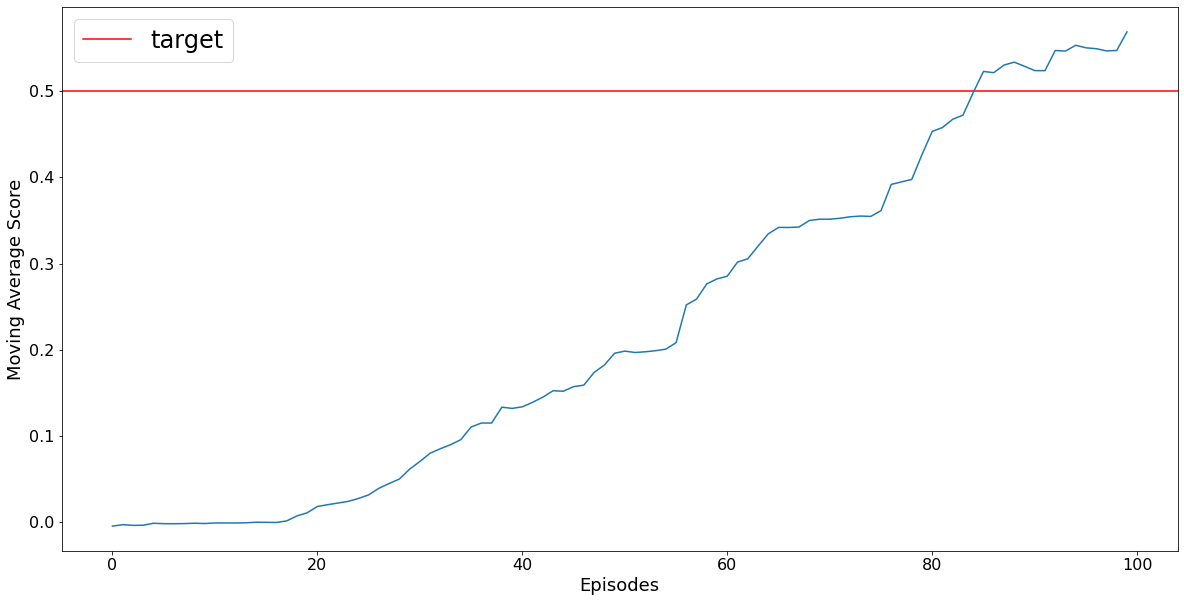

games:  4
Episode 101 	Score:2.39 	Average Score: 0.60
games:  1
Episode 102 	Score:2.60 	Average Score: 2.60
games:  7
Episode 103 	Score:2.39 	Average Score: 0.34
games:  16
Episode 104 	Score:2.04 	Average Score: 0.13
games:  8
Episode 105 	Score:2.16 	Average Score: 0.27
games:  5
Episode 106 	Score:2.37 	Average Score: 0.47
games:  4
Episode 107 	Score:2.59 	Average Score: 0.65
games:  2
Episode 108 	Score:2.49 	Average Score: 1.25
games:  3
Episode 109 	Score:2.48 	Average Score: 0.83
511 [True, True]
600 [True, True]
630 [True, True]
814 [True, True]
879 [True, True]
950 [True, True]
check score 110 0.10000000149011612 20 0.005000000074505806
games:  7
Episode 110 	Score:2.25 	Average Score: 0.32
games:  10
Episode 111 	Score:2.15 	Average Score: 0.22
games:  9
Episode 112 	Score:2.48 	Average Score: 0.28
games:  10
Episode 113 	Score:2.26 	Average Score: 0.23
games:  11
Episode 114 	Score:2.14 	Average Score: 0.19
games:  12
Episode 115 	Score:2.05 	Average Score: 0.17
games:  

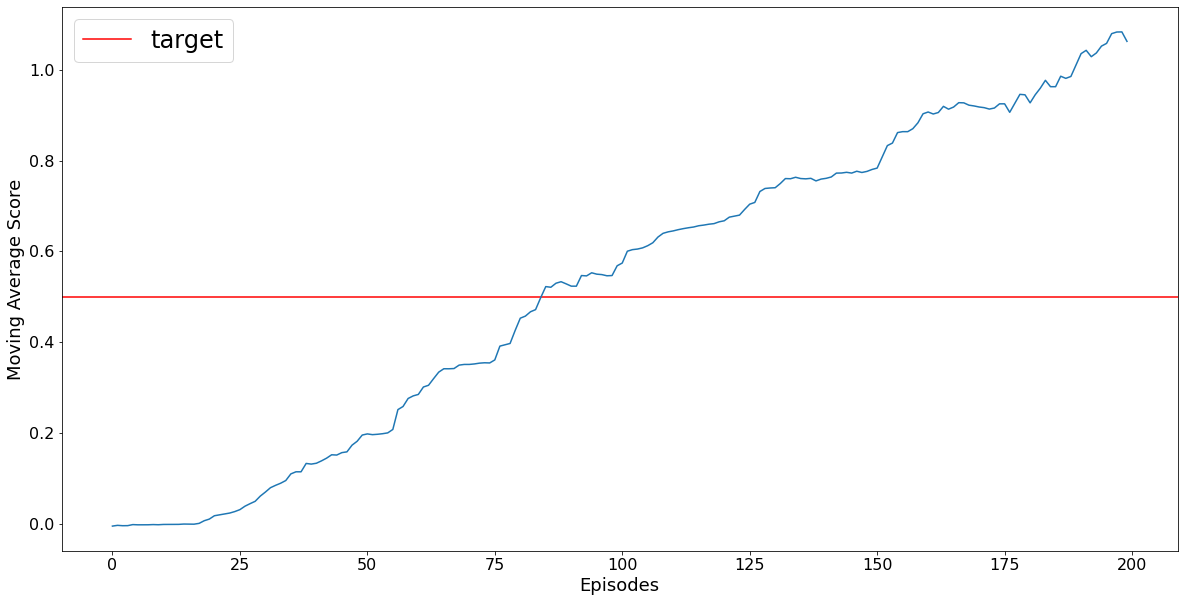

games:  11
Episode 201 	Score:2.18 	Average Score: 0.20
games:  12
Episode 202 	Score:2.05 	Average Score: 0.17
games:  9
Episode 203 	Score:2.36 	Average Score: 0.26
games:  10
Episode 204 	Score:2.04 	Average Score: 0.20
games:  9
Episode 205 	Score:2.47 	Average Score: 0.27
games:  4
Episode 206 	Score:2.38 	Average Score: 0.60
games:  3
Episode 207 	Score:2.70 	Average Score: 0.90
games:  7
Episode 208 	Score:2.27 	Average Score: 0.32
games:  5
Episode 209 	Score:2.38 	Average Score: 0.48
check score 210 0.0 15 0.0
games:  1
Episode 210 	Score:2.60 	Average Score: 2.60
games:  1
Episode 211 	Score:2.60 	Average Score: 2.60
games:  1
Episode 212 	Score:2.60 	Average Score: 2.60
games:  2
Episode 213 	Score:2.59 	Average Score: 1.30
games:  10
Episode 214 	Score:2.16 	Average Score: 0.22
games:  6
Episode 215 	Score:2.39 	Average Score: 0.40
games:  1
Episode 216 	Score:2.60 	Average Score: 2.60
games:  7
Episode 217 	Score:2.48 	Average Score: 0.35
games:  5
Episode 218 	Score:2.58 

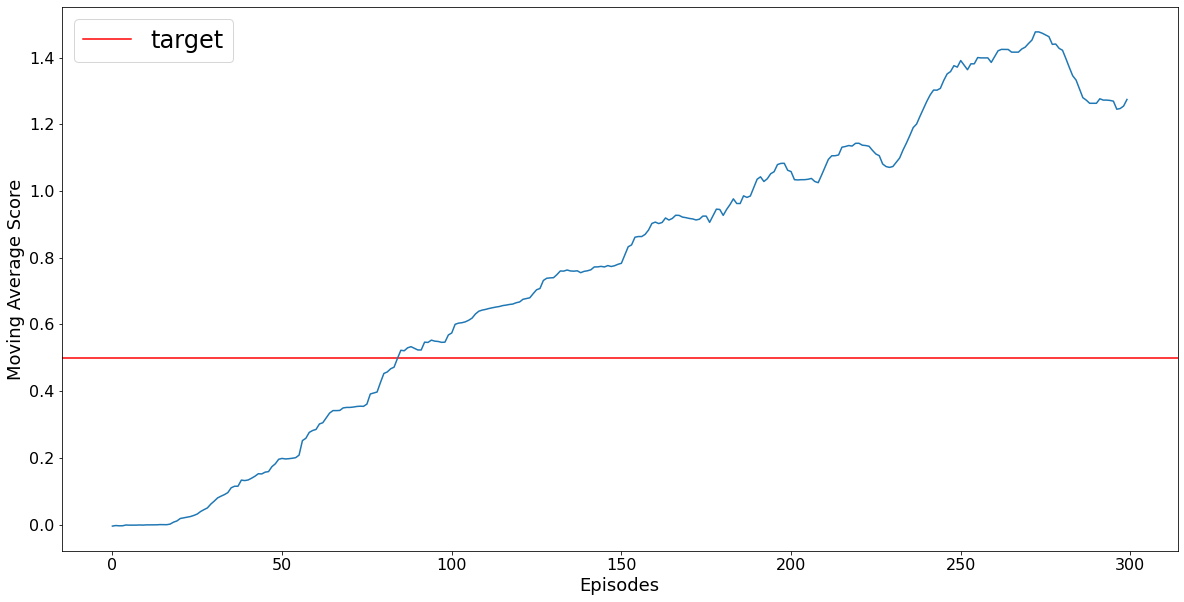

games:  1
Episode 301 	Score:2.60 	Average Score: 2.60
games:  2
Episode 302 	Score:2.49 	Average Score: 1.25
games:  6
Episode 303 	Score:2.37 	Average Score: 0.40
games:  4
Episode 304 	Score:2.59 	Average Score: 0.65
games:  2
Episode 305 	Score:2.59 	Average Score: 1.30
games:  1
Episode 306 	Score:2.60 	Average Score: 2.60
games:  3
Episode 307 	Score:2.60 	Average Score: 0.87
games:  2
Episode 308 	Score:2.50 	Average Score: 1.25
games:  9
Episode 309 	Score:2.25 	Average Score: 0.25
15 [True, True]
29 [True, True]
384 [True, True]
398 [True, True]
412 [True, True]
444 [True, True]
457 [True, True]
674 [True, True]
724 [True, True]
739 [True, True]
927 [True, True]
997 [True, True]
check score 310 -0.009999999776482582 13 -0.0007692307520371217
games:  13
Episode 310 	Score:2.17 	Average Score: 0.17
games:  7
Episode 311 	Score:2.55 	Average Score: 0.36
games:  3
Episode 312 	Score:2.38 	Average Score: 0.79
games:  9
Episode 313 	Score:2.04 	Average Score: 0.23
games:  1
Episode 

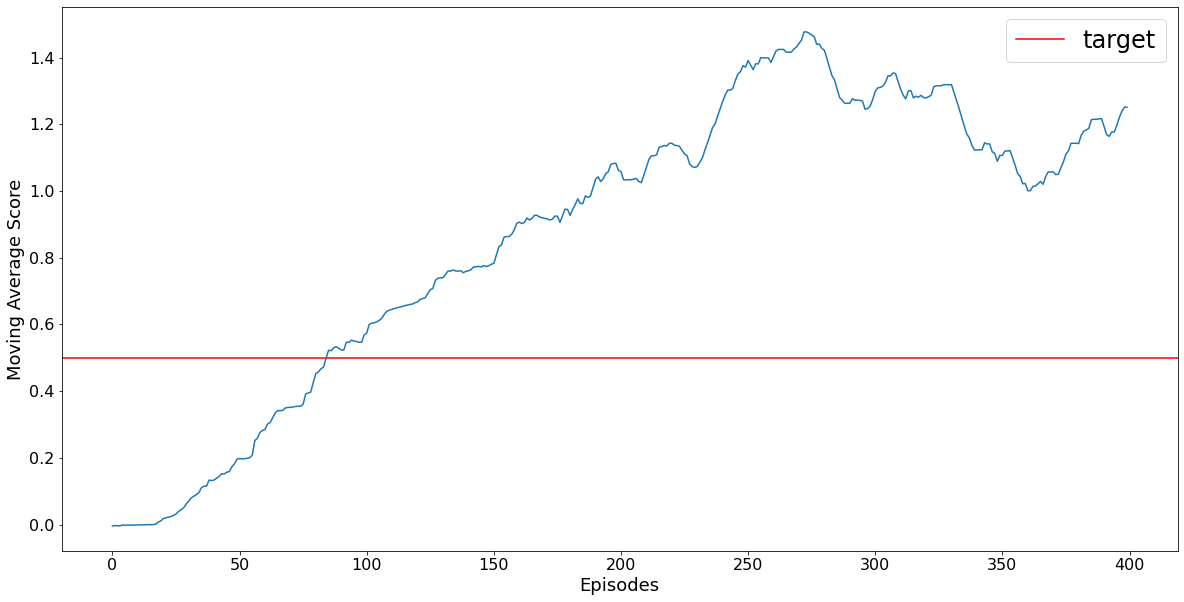

games:  1
Episode 401 	Score:2.60 	Average Score: 2.60
games:  1
Episode 402 	Score:2.60 	Average Score: 2.60
games:  2
Episode 403 	Score:2.70 	Average Score: 1.35
games:  1
Episode 404 	Score:2.60 	Average Score: 2.60
games:  1
Episode 405 	Score:2.60 	Average Score: 2.60
games:  1
Episode 406 	Score:2.70 	Average Score: 2.70
games:  1
Episode 407 	Score:2.60 	Average Score: 2.60
games:  2
Episode 408 	Score:2.50 	Average Score: 1.25
games:  2
Episode 409 	Score:2.70 	Average Score: 1.35
6 [True, True]
797 [True, True]
827 [True, True]
955 [True, True]
check score 410 -0.009999999776482582 8 -0.0012499999720603228
games:  5
Episode 410 	Score:2.59 	Average Score: 0.52
games:  1
Episode 411 	Score:2.60 	Average Score: 2.60
games:  5
Episode 412 	Score:2.48 	Average Score: 0.50
games:  4
Episode 413 	Score:2.48 	Average Score: 0.62
games:  3
Episode 414 	Score:2.59 	Average Score: 0.86
games:  6
Episode 415 	Score:2.49 	Average Score: 0.42
games:  1
Episode 416 	Score:2.60 	Average Sco

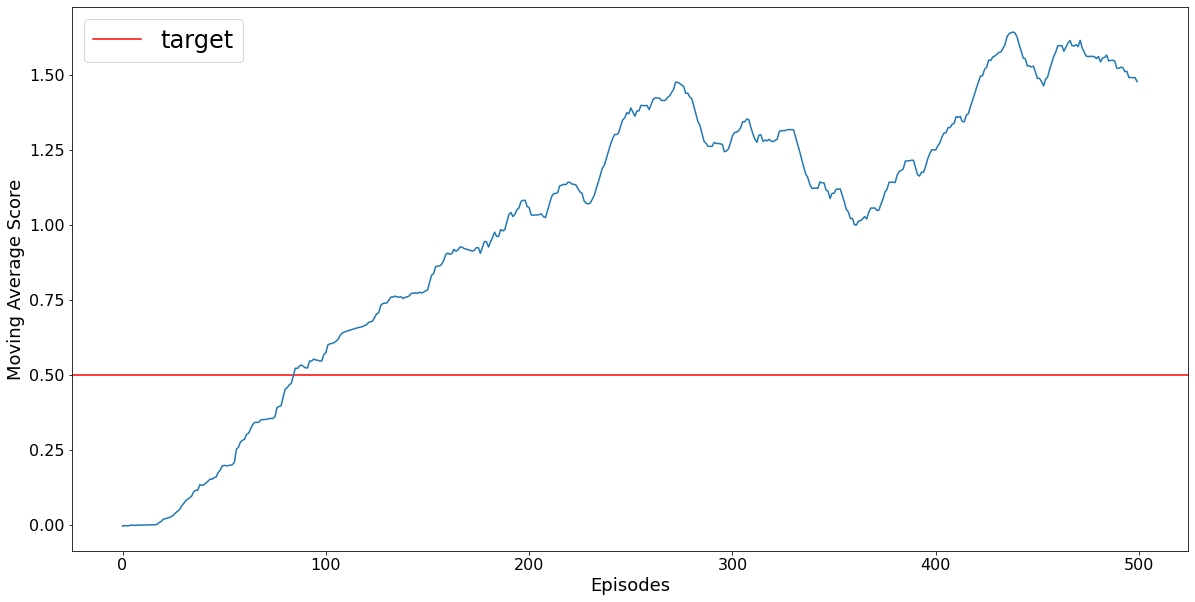

games:  2
Episode 501 	Score:2.59 	Average Score: 1.30
games:  1
Episode 502 	Score:2.60 	Average Score: 2.60
games:  1
Episode 503 	Score:2.60 	Average Score: 2.60
games:  1
Episode 504 	Score:2.70 	Average Score: 2.70
games:  1
Episode 505 	Score:2.60 	Average Score: 2.60
games:  1
Episode 506 	Score:2.60 	Average Score: 2.60
games:  1
Episode 507 	Score:2.70 	Average Score: 2.70
games:  1
Episode 508 	Score:2.60 	Average Score: 2.60
games:  1
Episode 509 	Score:2.60 	Average Score: 2.60
check score 510 0.0 9 0.0
games:  1
Episode 510 	Score:2.70 	Average Score: 2.70
games:  1
Episode 511 	Score:2.60 	Average Score: 2.60
games:  1
Episode 512 	Score:2.60 	Average Score: 2.60
games:  1
Episode 513 	Score:2.60 	Average Score: 2.60
games:  1
Episode 514 	Score:2.70 	Average Score: 2.70
games:  1
Episode 515 	Score:2.60 	Average Score: 2.60
games:  1
Episode 516 	Score:2.60 	Average Score: 2.60
games:  2
Episode 517 	Score:2.59 	Average Score: 1.30
games:  2
Episode 518 	Score:2.60 	Aver

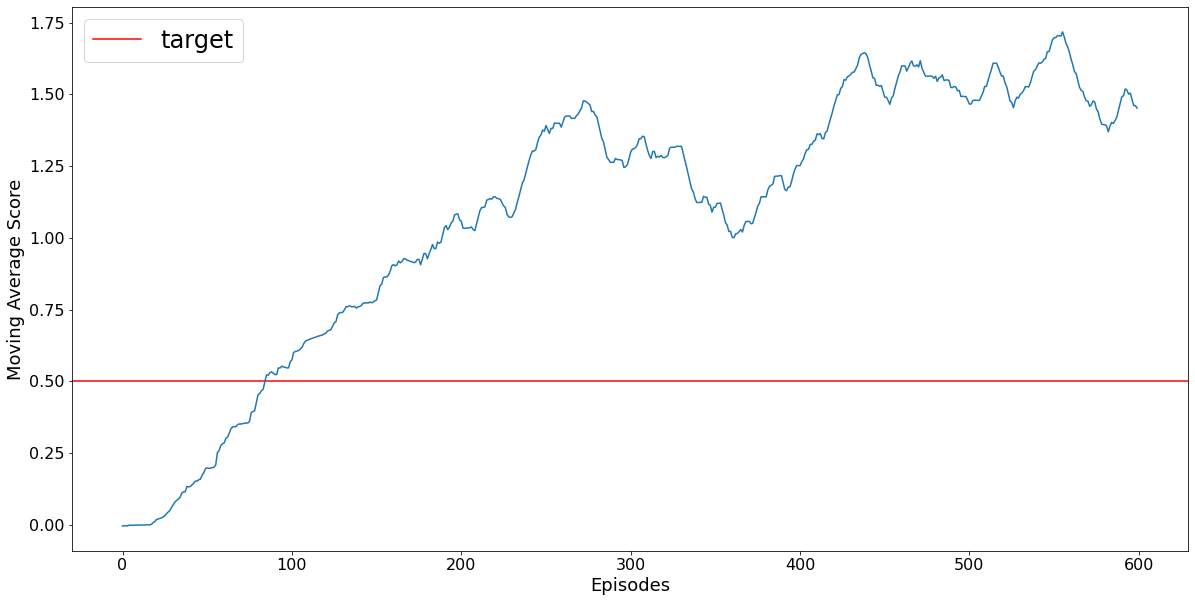

games:  5
Episode 601 	Score:2.38 	Average Score: 0.48
games:  6
Episode 602 	Score:2.37 	Average Score: 0.40
games:  11
Episode 603 	Score:1.94 	Average Score: 0.18
games:  5
Episode 604 	Score:2.36 	Average Score: 0.47
games:  8
Episode 605 	Score:2.27 	Average Score: 0.28
games:  14
Episode 606 	Score:2.04 	Average Score: 0.15
games:  6
Episode 607 	Score:2.37 	Average Score: 0.40
games:  7
Episode 608 	Score:2.16 	Average Score: 0.31
games:  4
Episode 609 	Score:2.59 	Average Score: 0.65
check score 610 0.10000000149011612 15 0.0066666667660077415
games:  1
Episode 610 	Score:2.60 	Average Score: 2.60
games:  17
Episode 611 	Score:2.06 	Average Score: 0.12
games:  7
Episode 612 	Score:2.17 	Average Score: 0.31
games:  8
Episode 613 	Score:2.26 	Average Score: 0.28
games:  1
Episode 614 	Score:2.60 	Average Score: 2.60
games:  9
Episode 615 	Score:2.28 	Average Score: 0.25
games:  2
Episode 616 	Score:2.49 	Average Score: 1.25
games:  5
Episode 617 	Score:2.28 	Average Score: 0.46
g

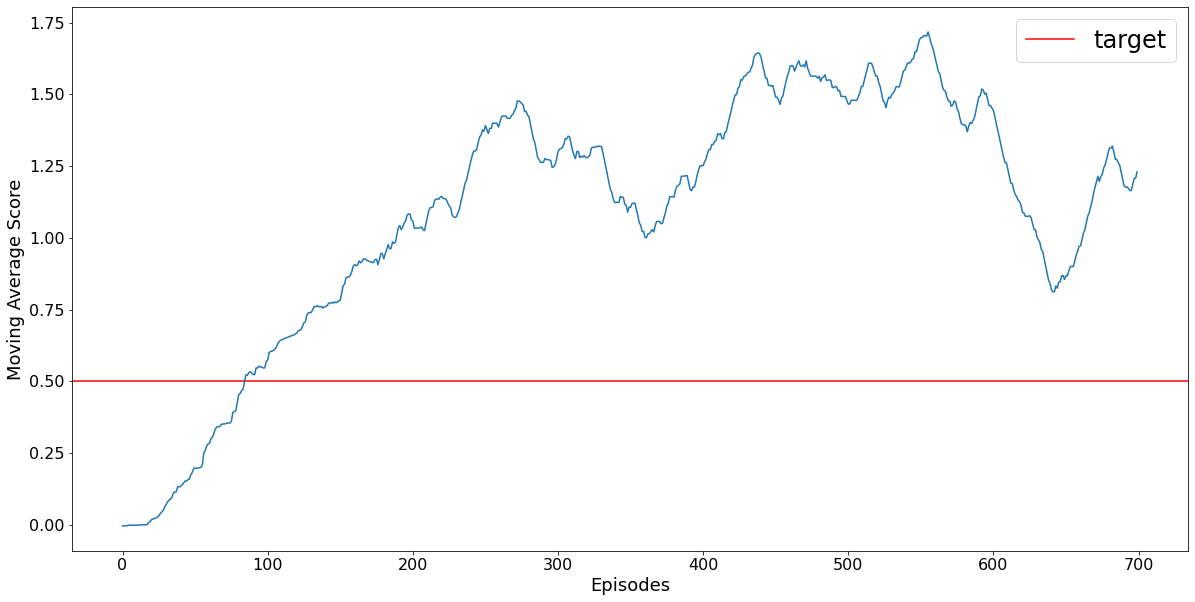

games:  1
Episode 701 	Score:2.60 	Average Score: 2.60
games:  3
Episode 702 	Score:2.48 	Average Score: 0.83
games:  2
Episode 703 	Score:2.59 	Average Score: 1.30
games:  1
Episode 704 	Score:2.60 	Average Score: 2.60
games:  3
Episode 705 	Score:2.49 	Average Score: 0.83
games:  1
Episode 706 	Score:2.70 	Average Score: 2.70
games:  1
Episode 707 	Score:2.60 	Average Score: 2.60
games:  1
Episode 708 	Score:2.60 	Average Score: 2.60
games:  8
Episode 709 	Score:2.15 	Average Score: 0.27
76 [True, True]
546 [True, True]
check score 710 0.10000000149011612 29 0.00344827591345228
games:  3
Episode 710 	Score:2.48 	Average Score: 0.83
games:  2
Episode 711 	Score:2.49 	Average Score: 1.25
games:  1
Episode 712 	Score:2.60 	Average Score: 2.60
games:  3
Episode 713 	Score:2.59 	Average Score: 0.86


KeyboardInterrupt: 

In [10]:
max_t = 1000
print_every = 100
scores_deque = deque(maxlen=print_every)
score_list = []
n_episodes = 500
agent.noise.reset()
for i_episode in range(1, n_episodes+1):
    env_info = env.reset(train_mode=False)[brain_name]     # reset the environment    
    state = env_info.vector_observations

    agent.noise.reset()
    scores = 0.0
    epi_score = []
    games = 1
    for t in range(max_t):
        action1 = agent.act(state[0:1,]) 
        action2 = agent.act(state[1:2,]) 
        
        actions = np.vstack([action1,action2])
        env_info = env.step(actions)[brain_name] 
        
        reward = env_info.rewards 
        reward = reward[0]
        
        next_state = env_info.vector_observations 
        dones = env_info.local_done  
        done = dones[0]
        
        agent.step(state[0:1], action1, reward, next_state[0:1])
        agent.step(state[1:2], action2, reward, next_state[1:2])
        state = next_state
        
        scores += reward    
        if np.any(dones):                                  # exit loop if episode finished
            games += 1
            if i_episode % 10 == 0:
                print(t, dones)
        
    scores_deque.append(scores/games)
    score_list.append(np.mean(scores_deque))
    print('games: ',games)
    print('\rEpisode {} \tScore:{:.2f} \tAverage Score: {:.2f}'.format(i_episode, scores, scores/games))
    if i_episode % print_every == 0:
        print('\rEpisode {}\tAverage Score: {:.2f}'.format(i_episode, np.mean(scores_deque)))        
        ## Save the model along with some training information
        checkpoint = {
            'actor_dict': agent.actor_local.state_dict(),
            'critic_dict': agent.critic_local.state_dict(),
            'episodes': i_episode,
            'scores': scores,
            }
        print('\nSaving model ...', end=' ')
        torch.save(checkpoint, 'ddpg_agent.pt')
        print('done.')
        
        plt.figure(figsize=(20,10))
        plt.axhline(y=0.5,c='r',label='target')
        plt.plot(score_list)
        plt.legend(fontsize=24)
        plt.xlabel('Episodes', fontsize=18)
        plt.ylabel('Moving Average Score', fontsize=18)
        plt.xticks(fontsize= 16)
        plt.yticks(fontsize= 16)
        plt.savefig('Performance_at{}.jpg'.format(i_episode))
        plt.show()

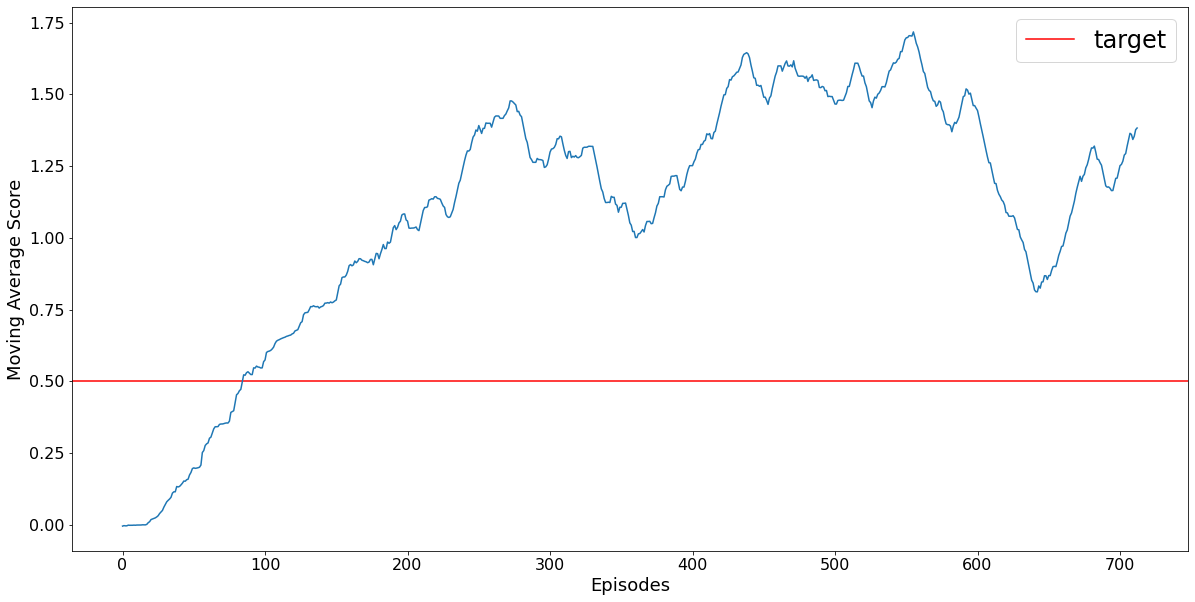

In [11]:
plt.figure(figsize=(20,10))
plt.axhline(y=0.5,c='r',label='target')
plt.plot(score_list)
plt.legend(fontsize=24)
plt.xlabel('Episodes', fontsize=18)
plt.ylabel('Moving Average Score', fontsize=18)
plt.xticks(fontsize= 16)
plt.yticks(fontsize= 16)
plt.savefig('Performance.jpg')
plt.show()

In [12]:
# Load the trained model
checkpoint = torch.load('ddpg_agent.pt', map_location='cpu')
agent = Agent(state_size, action_size, random_seed=0)
agent.actor_local.load_state_dict(checkpoint['actor_dict'])
agent.critic_local.load_state_dict(checkpoint['critic_dict'])

DDPG Agent hyperparameters:
	batch size: 		     128
	buffer size: 		  100000
	discount / gamma: 	   0.990
	actor learning rate: 	   0.000
	critic learning rate: 	   0.001
	soft update / tau: 	   0.001
	noise decay rate: 	   0.999

Actor network built: ModuleList(
  (0): Linear(in_features=24, out_features=400, bias=True)
  (1): Linear(in_features=400, out_features=300, bias=True)
  (2): Linear(in_features=300, out_features=2, bias=True)
)
Actor network built: ModuleList(
  (0): Linear(in_features=24, out_features=400, bias=True)
  (1): Linear(in_features=400, out_features=300, bias=True)
  (2): Linear(in_features=300, out_features=2, bias=True)
)
Critic network built: ModuleList(
  (0): Linear(in_features=24, out_features=400, bias=True)
  (1): Linear(in_features=402, out_features=300, bias=True)
  (2): Linear(in_features=300, out_features=1, bias=True)
)
Critic network built: ModuleList(
  (0): Linear(in_features=24, out_features=400, bias=True)
  (1): Linear(in_features=402, out_feat

When finished, you can close the environment.

In [ ]:
## Watch the agent performing in the environment
scores_episode = np.zeros(num_agents)
env_info = env.reset(train_mode=False)[brain_name]     # reset the environment    
state = env_info.vector_observations
for i in range(1000):
    print(i)
    actions = agent.act(states, noise=False)
    env_info = env.step(actions)[brain_name]
    states = env_info.vector_observations
    rewards = env_info.rewards
    scores_episode += rewards

print('Score for this episode: {:.2f}'.format(scores_episode.mean()))

In [10]:
env.close()

### 4. It's Your Turn!

Now it's your turn to train your own agent to solve the environment!  When training the environment, set `train_mode=True`, so that the line for resetting the environment looks like the following:
```python
env_info = env.reset(train_mode=True)[brain_name]
```